In [108]:
%pylab inline
import pandas as pd
import SpatialDE as sde

Populating the interactive namespace from numpy and matplotlib


In [109]:
sample_info = pd.read_csv('Frog_sample_info.csv', index_col=0)

In [110]:
df = pd.read_csv('data/GSE65785_clutchApolyA_relative_TPM.csv', index_col=0)
df = df[sample_info.index]
df = df[df.sum(1) >= 3]  # Filter practically unobserved genes
dfm = np.log10(df + 1).T

In [111]:
import NaiveDE

In [112]:
dfm = NaiveDE.stabilize(df).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(ERCC) + np.log(num_genes)', rcond=1e-4).T

In [113]:
results = pd.read_csv('Frog_final_results.csv')

In [114]:
results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

In [115]:
results.model.value_counts()

SE    22256
Name: model, dtype: int64

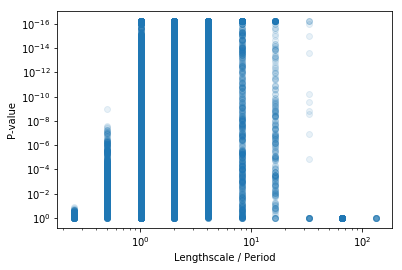

In [116]:
plt.loglog()
plt.scatter(results.l, results.pval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Lengthscale / Period')
plt.ylabel('P-value');

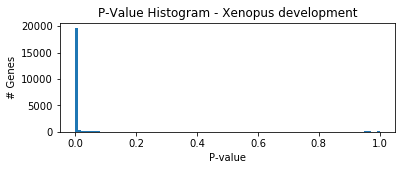

In [117]:
figsize(6, 2)
plt.hist(results.pval, bins=100);
plt.title('P-Value Histogram - Xenopus development')
plt.ylabel('# Genes')
plt.xlabel('P-value');

In [118]:
results.query('qval < 0.05').shape

(21005, 16)

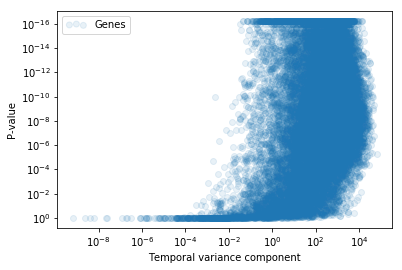

In [119]:
figsize(6, 4)

plt.loglog()
plt.scatter(results.max_s2_t_hat, results.pval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Temporal variance component')
plt.ylabel('P-value');

plt.legend(scatterpoints=3);

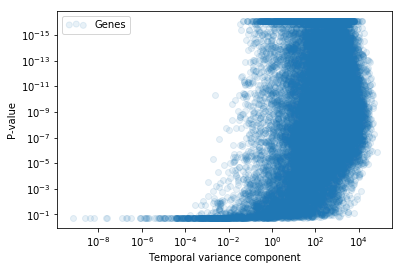

In [134]:
figsize(6, 4)

plt.loglog()
plt.scatter(results.max_s2_t_hat, results.qval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Temporal variance component')
plt.ylabel('P-value');

plt.legend(scatterpoints=3);

In [120]:
N = 5
top_per_ls = results.query('qval < 0.05') \
                  .sort_values('qval', ascending=True) \
                  .groupby('l') \
                  .head(N) \
                  .sort_values(['l', 'qval'], ascending=[True, True])
                
top_per_ls.shape

(40, 16)

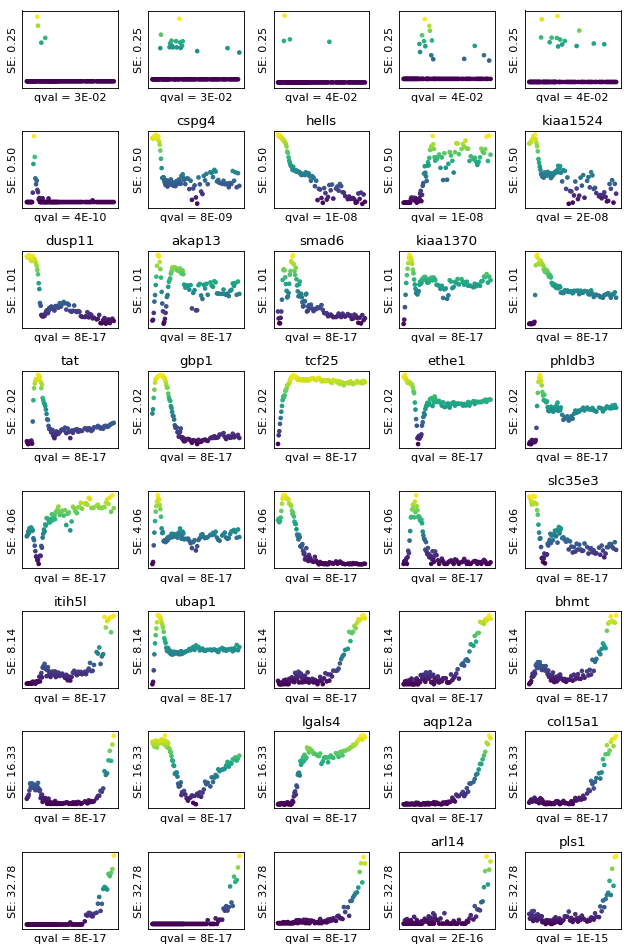

In [121]:
plt.figure(figsize=(8, 12), dpi=80)

N = 5
N_rows = top_per_ls['l'].unique().shape[0]
for j, T in enumerate(top_per_ls.groupby('l')):
    _, group = T
    for i, idx in enumerate(group.index):
        r = top_per_ls.loc[idx]
        plt.subplot(N_rows, N, j * N + i + 1)
        plt.scatter(sample_info.hpf, dfm[r['g']], c=dfm[r['g']], s=10, rasterized=True);
        plt.title(r['g'].split('|')[-1].replace('unnamed', ''))
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('qval = {:.0E}'.format(r['qval']))
        if True:
            plt.ylabel('{}: {:.2f}'.format(r['model'], r['l']))

plt.tight_layout()
plt.savefig('top_frog_gene_grid.pdf')

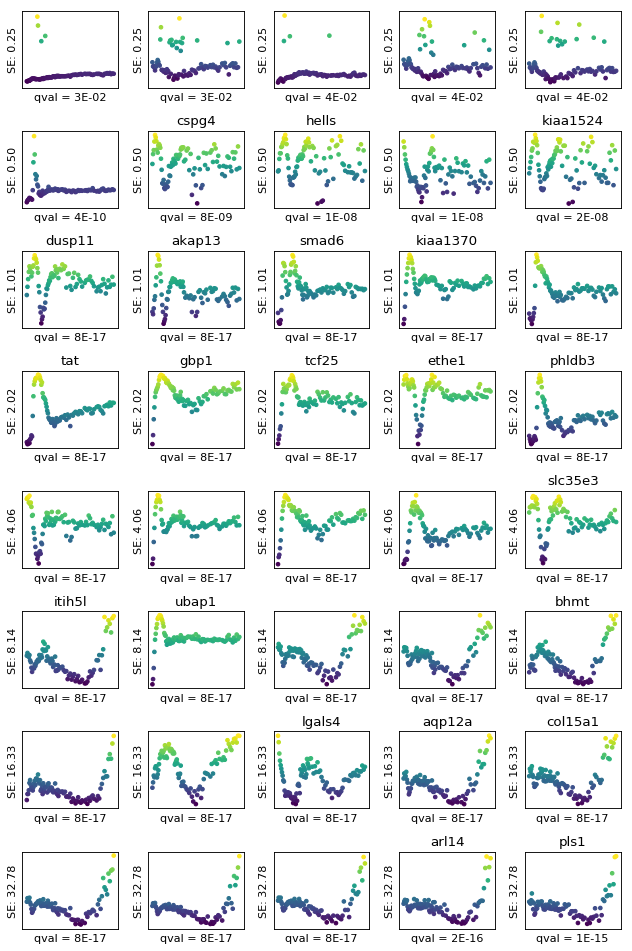

In [122]:
plt.figure(figsize=(8, 12), dpi=80)

N = 5
N_rows = top_per_ls['l'].unique().shape[0]
for j, T in enumerate(top_per_ls.groupby('l')):
    _, group = T
    for i, idx in enumerate(group.index):
        r = top_per_ls.loc[idx]
        plt.subplot(N_rows, N, j * N + i + 1)
        plt.scatter(sample_info.hpf, res[r['g']], c=res[r['g']], s=10, rasterized=True);
        plt.title(r['g'].split('|')[-1].replace('unnamed', ''))
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('qval = {:.0E}'.format(r['qval']))
        if True:
            plt.ylabel('{}: {:.2f}'.format(r['model'], r['l']))

plt.tight_layout()
# plt.savefig('top_frog_gene_grid.pdf')

In [123]:
from adjustText import adjust_text

6


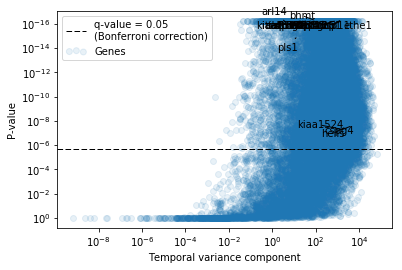

In [124]:
figsize(6, 4)

plt.loglog()
plt.scatter(results.max_s2_t_hat, results.pval, label='Genes', alpha=0.1, rasterized=True);

texts = []
for i in top_per_ls.index:
    if results.loc[i, 'max_s2_t_hat'] == 0.:
        continue

    gname = results.loc[i, 'g'].split('|')[-1].replace('unnamed', '')
    texts.append(plt.text(results.loc[i, 'max_s2_t_hat'], results.loc[i, 'pval'], gname))
    
print(adjust_text(texts, arrowprops=dict(arrowstyle='-'),
                         force_points=0.1,
                         force_text=0.5,
                         force_objects=0.1,
                         zorder=20,
#                          x=results['max_s2_t_hat'],
#                          y=results['pval'],
                 ))


plt.gca().invert_yaxis();
plt.xlabel('Temporal variance component')
plt.ylabel('P-value');

plt.axhline(0.05 / results.shape[0], label='q-value = 0.05\n(Bonferroni correction)', lw=1, linestyle='--', c='k');
plt.legend(scatterpoints=3);
plt.savefig('frog_gene_sigma_pval.pdf')

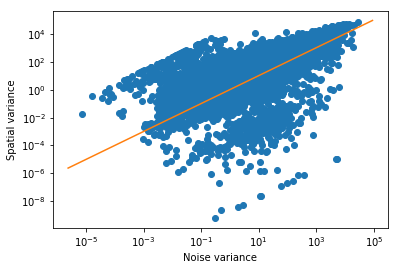

In [125]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.max_delta * results.max_s2_t_hat, results.max_s2_t_hat)
plt.xlabel('Noise variance')
plt.ylabel('Spatial variance');

x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, c='C1');


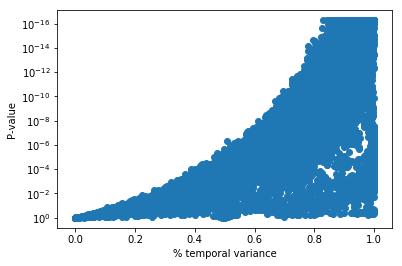

In [126]:
plt.yscale('log')
total_variance = results.max_delta * results.max_s2_t_hat + results.max_s2_t_hat
plt.scatter(results.max_s2_t_hat / total_variance, results.pval)
plt.gca().invert_yaxis();
plt.xlabel('% temporal variance')
plt.ylabel('P-value');

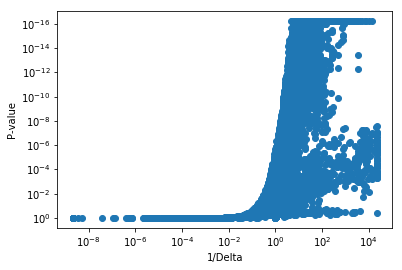

In [127]:
plt.yscale('log')
plt.xscale('log')

for i, g in results.groupby('model'):
    plt.scatter(1. / g.max_delta, g.pval)
    

plt.gca().invert_yaxis();
plt.xlabel('1/Delta')
plt.ylabel('P-value');

In [128]:
results.sort_values('qval', ascending=True).query('qval < 0.05').head(20)

,Unnamed: 0,g,max_delta,max_ll,max_mu_hat,max_s2_t_hat,n,time,l,M,model,BIC,max_ll_null,LLR,pval,qval
4486,4486,Xetro.G01740|ppp1r12c,0.019354,32.317279,0.755251,0.273776,89,0.000657,1.006862,4,SE,-46.680012,-41.586493,73.903772,5.551115e-17,7.611617e-17
9255,9255,Xetro.C00442|nudcd3,0.022310,99.038707,12.008546,22.632370,89,0.000646,2.020620,4,SE,-180.122869,19.797139,79.241568,5.551115e-17,7.611617e-17
18963,18963,Xetro.C01777|nell2,0.029388,44.910117,-44.822046,167.774544,89,0.000470,4.055081,4,SE,-71.865689,-34.782571,79.692688,5.551115e-17,7.611617e-17
10905,10905,Xetro.D01973|ttc39a,0.046091,26.088485,-13.310914,27.714590,89,0.000479,2.020620,4,SE,-34.222425,-67.149067,93.237552,5.551115e-17,7.611617e-17
10904,10904,Xetro.D01970|faf1,0.090229,69.450202,37.351911,214.353494,89,0.000556,2.020620,4,SE,-120.945859,-11.458198,80.908400,5.551115e-17,7.611617e-17
15572,15572,Xetro.I01438|cluap1,0.058833,51.230085,36.020020,200.935549,89,0.000558,2.020620,4,SE,-84.505625,-38.059295,89.289380,5.551115e-17,7.611617e-17
19977,19977,Xetro.G01929|,0.087949,50.672889,42.701426,149.660088,89,0.000658,4.055081,4,SE,-83.391232,-19.984266,70.657155,5.551115e-17,7.611617e-17
19975,19975,Xetro.G01926|unnamed,0.003982,27.438814,8.184270,7.716560,89,0.000639,4.055081,4,SE,-36.923082,-73.004506,100.443319,5.551115e-17,7.611617e-17
15570,15570,Xetro.I01432|,0.120675,86.189540,-15.006068,34.380052,89,0.000562,2.020620,4,SE,-154.424535,15.998102,70.191438,5.551115e-17,7.611617e-17
15568,15568,Xetro.I01430|xpo6,0.054191,13.171815,118.262059,2167.912475,89,0.000645,2.020620,4,SE,-8.389084,-78.702715,91.874530,5.551115e-17,7.611617e-17


In [129]:
from sklearn.preprocessing import scale

In [130]:
top_genes = results.sort_values('qval', ascending=True).head(400)

In [131]:
idx = np.argsort(np.argmax(res[top_genes['g']].as_matrix(), 0))[::-1]

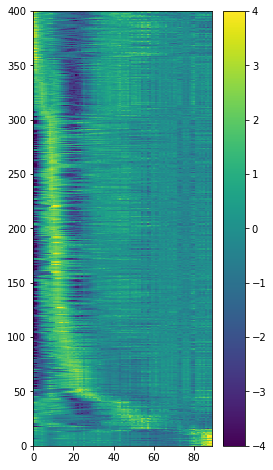

In [132]:
figsize(4, 8)
plt.pcolormesh(scale(res[top_genes.iloc[idx]['g']].T, 1), vmax=4, vmin=-4);
plt.colorbar()

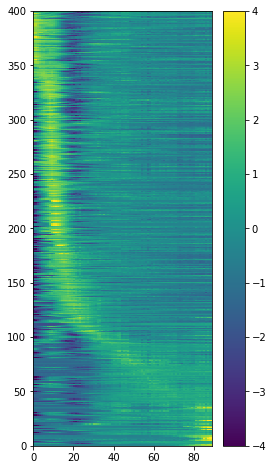

In [133]:
idx = np.argsort(np.argmax(dfm[top_genes['g']].as_matrix(), 0))[::-1]

figsize(4, 8)
plt.pcolormesh(scale(dfm[top_genes.iloc[idx]['g']].T, 1), vmax=4, vmin=-4);
plt.colorbar()